In [2]:
%matplotlib inline

import os 
import sys 
import time
import hashlib

from datetime  import datetime 

import numpy as np  # learn 
import pandas as pd # learn
from pandas import *
from numpy import *

from scipy import stats # look at scipy
from scipy import linalg
from scipy import *
 
import matplotlib as mplt # learn matplolib 
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# import seaborn as sns 
# sns.set_style("whitegrid")
# sns.set(rc={"figure.figsize": (14, 6)})

import IPython
from IPython.display import display


import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
 
# import sklearn as sk
import itertools

# from pyspark import SparkContext, SparkConf
# from pyspark.sql import SQLContext
# from pyspark.sql.types import *
# from pyspark.mllib.regression import LabeledPoint

from keras.models import Sequential 
from keras.layers.core import Dense, Activation, TimeDistributedDense, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import *
# RMSprop, Adadelta
from keras.regularizers import l2, activity_l2

import scipy.stats as st


from random import random

import copy
# http://sebastianruder.com/optimizing-gradient-descent/
# https://leemendelowitz.github.io/blog/how-does-python-find-packages.html

Using Theano backend.


In [7]:
# block1: Training dataset

# load and extract yahoo data
# choose the data in files real_11-20, which contains a time series (data point 3000 - 10000) with mediate 
# outlier magnitude 

# this dataset will be used for realtime training RNN 
# 6,13,15,11,22,29,56,31,39,57,43,65, 55,62


# 13 23 29 44
# final chosen one: 2,3

figsize= ( 10,5)

def value_drift_plot( ts, file_name ):
    valDrift =  [ ts[i+1]-ts[i] for i in range(len(ts)-1) ]
    
    fig = plt.figure()
    figure_size= figsize
    fig.set_size_inches( figure_size )

    axes = plt.gca()
#     axes.set_xlim([1, len(ts)+10])
#     axes.set_ylim([-2000,maxval+2000])

    plt.plot( valDrift, label='value drifts: x_t - t_(t-1)' )
# plt.plot( list( clean_tdf['value']), color='g' )
# plt.scatter( list(outlier_tdf['timestamp']),list(outlier_tdf['value']), color='red',\
#              label='Outliers')
# plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


# axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
# axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Value drift in ' + file_name )
    plt.ylabel('Value')
    plt.xlabel('Time')
# plt.legend( loc='upper left',fontsize=12 )
    plt.legend() 

    
def yahooSyn_load_data_plot( dta_file):
    
    tmpdf= pd.read_csv( dta_file )
    
    tmpdf.drop('timestamps', axis=1, inplace=True)
    tmp_col=  range( 1, tmpdf.shape[0]+1 ) 
    tmpdf.insert(0, 'timestamps', tmp_col)
    tdf= tmpdf
    
#   print "size of noisy data:", tdf.shape
    
    maxval= max(tdf['value'])
    minval= min(tdf['value'])
    outliers= tdf[ tdf['anomaly'] ==1  ]
    cps= tdf[ tdf['changepoint'] ==1  ]
    
    ts_flag= list(tdf['anomaly'])

    figure_size= figsize
    legend_font= 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )

    plt.plot( list( tdf['value']), label='Normal data' )
    plt.scatter( list(outliers['timestamps']),list(outliers['value']), color='red',\
                label='Outliers'  )
#     plt.scatter( list(cps['timestamps']),list(cps['value']), color='green',\
#                 label='Changepoints'  )
    for i in list(cps['timestamps']):
        plt.axvline(x=i, color='k',ls='dashed', linewidth=4.0)
    
    axes = plt.gca()
    axes.set_xlim([1, tdf.shape[0]+10])
  
    plt.title('Yahoo Synthetic Data')
    plt.ylabel('Value')
    plt.xlabel('Time (seconds)')
    plt.legend()
#     plt.legend(loc=0, ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font 
# , numpoints=1 )
    
#     value_drift_plot( list(tdf['value']), 'real_'+str(fileNo) )  
    
    return tdf['value'], ts_flag, list(cps['timestamps'])

def yahoo_load_data( dta_file):
    
    is_clean=0
    
    tmpdf= pd.read_csv( dta_file )
    tmpdf.drop('timestamp', axis=1, inplace=True)
    tmp_col=  range( 1, tmpdf.shape[0]+1 ) 
    tmpdf.insert(0, 'timestamp', tmp_col)
    tdf= tmpdf
        
    maxval= max(tdf['value'])
    minval= min(tdf['value'])

    outlier_tdf= tdf[ tdf['is_anomaly'] ==1  ]
    clean_tdf =  tdf[ tdf['is_anomaly'] ==0  ]

    if is_clean==1:
        ts= clean_tdf['value']
    else:
        ts= tdf['value']
    
    ts_flag= list(tdf['is_anomaly'])

#     print "size of clean data:",clean_tdf.shape
#     print "size of noisy data:", ts.shape, len(ts_flag)
#     print outlier_tdf
    
    # .............plot.................

    matplotlib.rcParams.update({'font.size': 15})
    figure_size= figsize
    legend_font= 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )

    axes = plt.gca()
    axes.set_xlim([1, tdf.shape[0]+10])
    axes.set_ylim([-50000,300000])

    plt.plot( list( tdf['value']), label='Normal data' )
    # plt.plot( list( clean_tdf['value']), color='g' )
    plt.scatter( list(outlier_tdf['timestamp']),list(outlier_tdf['value']), color='red',\
             label='Outliers',s=50)
#                 marker='+')
    # plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


    # axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
    # axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Yahoo Real Data')
    plt.ylabel('Value')
    plt.xlabel('Time')
    # plt.legend( loc='upper left',fontsize=12 )
    plt.legend(loc='upper left')
    #     bbox_to_anchor=(0., 1.0, 1., .10),
    #            loc=0,
    #            ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font , numpoints=1 )

#     value_drift_plot( list(tdf['value']), 'real_'+str(fileNo) )  
    
    #     fig.savefig('example_ts.pdf', format='pdf', bbox_inches='tight')
    
    
    return ts, ts_flag
    

# def activity_load_data_plot( fileNo,  dta_folder):

    
# ax.annotate('local max', xy=(3, 1),  xycoords='data',
#             xytext=(0.8, 0.95), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             horizontalalignment='right', verticalalignment='top',
#             )

def plot_outlier( ts_t, ts_val, out_t, out_val, dataset_name):
    
    matplotlib.rcParams.update({'font.size': 15})
    figure_size= figsize
    legend_font= 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )

    axes = plt.gca()
#     axes.set_xlim([1, tdf.shape[0]+10])
    # axes.set_ylim([-2000,maxval+2000])

    plt.plot( ts_t, ts_val ,label='Normal data' )
    # plt.plot( list( clean_tdf['value']), color='g' )
    plt.scatter( out_t ,out_val, color='red',label='Outliers')
    # plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
    # axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(dataset_name)
    plt.ylabel('Value')
    plt.xlabel('Time')
    # plt.legend( loc='upper left',fontsize=12 )
    plt.legend(loc='upper left')
    #     bbox_to_anchor=(0., 1.0, 1., .10),
    #            loc=0,
    #            ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font , numpoints=1 )

#     value_drift_plot( ts_val , dataset_name )  
    
    #     fig.savefig('example_ts.pdf', format='pdf', bbox_inches='tight')
    
def plot_outlier_cp( ts_t, ts_val, out_t, out_val, cp_t,cp_val, dataset_name):
    
    matplotlib.rcParams.update({'font.size': 15})
    figure_size= figsize
    legend_font= 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )

    axes = plt.gca()
    #axes.set_xlim([1, tdf.shape[0]+10])
    #axes.set_ylim([-2000,maxval+2000])

    plt.plot( ts_t, ts_val, label='Normal data' )
    #plt.plot( list( clean_tdf['value']), color='g' )
    plt.scatter( out_t ,out_val, color='red',label='Outliers',s=60)
    plt.scatter( cp_t ,cp_val, color='green',label='Change-Points',s=100, marker='*')

    # plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
    # axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(dataset_name)
    plt.ylabel('Value')
    plt.xlabel('Time')
    # plt.legend( loc='upper left',fontsize=12 )
    plt.legend(loc='upper left')
    #     bbox_to_anchor=(0., 1.0, 1., .10),
    #            loc=0,
    #            ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font , numpoints=1 )

    #     value_drift_plot( ts_val , dataset_name)  
    
    #     fig.savefig('example_ts.pdf', format='pdf', bbox_inches='tight')
    
def plot_plain(ts_t, ts_val, dataset_name):
    
    matplotlib.rcParams.update({'font.size': 15})
    figure_size= figsize
    legend_font= 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )

    axes = plt.gca()
#     axes.set_xlim([1, tdf.shape[0]+10])
#     axes.set_ylim([yrange[0], yrange[1]])

    plt.plot( ts_t, ts_val, label='Normal data' )
    # plt.plot( list( clean_tdf['value']), color='g' )

    # plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
    # axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(dataset_name)
    plt.ylabel('Value')
    plt.xlabel('Time')
    # plt.legend( loc='upper left',fontsize=12 )
    plt.legend(loc='upper left')
    #     bbox_to_anchor=(0., 1.0, 1., .10),
    #            loc=0,
    #            ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font , numpoints=1 )

#     value_drift_plot( ts_val , dataset_name )  
    
    #     fig.savefig('example_ts.pdf', format='pdf', bbox_inches='tight')
    
def load_dataset(file_path, column, st,ed, seperator, drop_na_bool):
    
    tmpdf= pd.read_csv( file_path , sep=seperator)

    if drop_na_bool == True:
        tmpdf = tmpdf.dropna(axis=0)
    print tmpdf.shape

    tmplist = list(tmpdf[ column ])
    tmplist = [float(i)  for i in tmplist]
    
    tmplist = tmplist[st:ed]
    
    tpoints= range(len( tmplist ))
    
    return tmplist, tpoints


def outlier_detection( ts_list ):
    
    tmplen= len(ts_list)

    return ts_flag

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


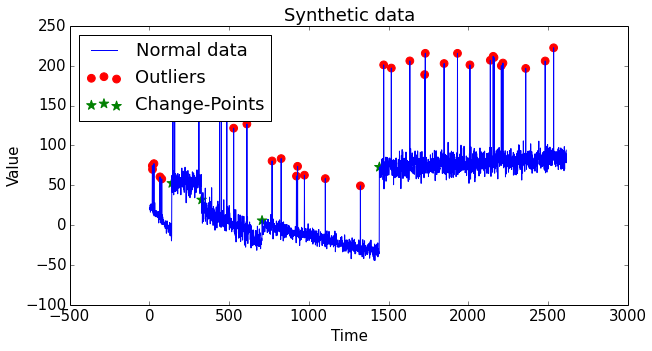

In [9]:
# load labelled data
ts_arr=[] 
tp_arr=[]
ts_flag_arr=[]
ts_cpt_arr=[]
yrange_arr=[]

dataset_names=[ "Synthetic","YSyn", "YReal"]


# ---- synthetic data ----------
data_file= "/home/guo/RNN/dataset/synthetic/"+"syn_dta_trend7.csv"

tmpdf= pd.read_csv( data_file ,sep=',')
col = tmpdf.columns

ts = list(tmpdf[ col[0] ])
ts = [float(i)  for i in ts]
tmp_flag= list(tmpdf[ col[2] ])

cp= tmpdf[ col[1] ]
cp = list(zip(cp, range( len(ts) )))
cp_t = [  i[1]   for i in cp if i[0]==1]
cp_val = [  ts[i] for i in cp_t]

out=tmpdf[ col[2] ]
out =list( zip(out, range( len(ts) )))
out_t = [  i[1]   for i in out if i[0]==1]
out_val = [  ts[i] for i in out_t]

plot_outlier_cp( range(len(ts)), ts, out_t, out_val, cp_t,cp_val, 'Synthetic data')

ts_arr.append(ts)
ts_flag_arr.append(tmp_flag)

ts_cpt_arr.append( cp_t  )
yrange_arr.append([-100, 250]  )

# # -----------------------------------------

# # YAHOO SYN

# data_file= ""

# tmpts, tmpts_flag, cpt = yahooSyn_load_data_plot( data_file )
# # 77
# # 85

# # YAHOO REAL

# ts_arr.append(tmpts)
# ts_flag_arr.append(tmpts_flag)
# ts_cpt_arr.append(cpt)
# yrange_arr.append([-3000, 6000]  )

# # -----------------------------------------

# dta_folder=""

# tmpts, tmpts_flag = yahoo_load_data(29, dta_folder)

# ts_arr.append(tmpts)
# ts_flag_arr.append(tmpts_flag)
# ts_cpt_arr.append([])
# yrange_arr.append([-50000, 300000]  )


In [13]:
# block2: data pre-processing

# re-organize the data to the format for feeding into the RNN 

def extract_load_data( ts_df, st_idx, ed_idx):
    tmpdta = ts_df.iloc[st_idx: ed_idx]
    cnt= len(tmpdta)
    tmpx=[]
    tmpy=[]
    for i in range(cnt-1):
        tmpx.append( tmpdta.iloc[i].as_matrix() )
        tmpy.append( tmpdta.iloc[i+1].as_matrix() )

    return tmpx, tmpy, tmpdta.iloc[cnt-1].as_matrix()

def format_timeseries_rnn(ts):
    tmptrnx =[]
    tmptrny =[]
    
    ts_df= pd.DataFrame(ts)
    
    tmpPre = 0
    tmpCur = len(ts)
    
    tmpx,tmpy, tmpy1 = extract_load_data( ts_df, tmpPre,tmpCur)
    tmptrnx.append(tmpx)
    tmptrny.append(tmpy)
    
    # qualified format for rnn
    dtax = np.array( tmptrnx )
    dtay = np.array( tmptrny )

#     print dtax.shape, dtay.shape
    return dtax, dtay

In [26]:
print type(dtax)
print dtax.shape

a=[]
a.append([1,2])
a.append([3,4])

<type 'numpy.ndarray'>
(1, 2614, 1)


In [12]:
# block3:  RNN configureation

hidden_neurons = 450

# learning rate
lr_val = 0.001

# all the available optimizers
sgd = SGD(lr= lr_val, momentum=0.03, decay=0.0, nesterov=True)
rms = RMSprop(lr= lr_val, rho=0.9, epsilon=1e-06)

#Keras says: it is recommended to leave the parameters of this optimizer 
# at their default values for the two optimizers below
adagrad = Adagrad(lr=0.01, epsilon=1e-06)
adadelta = Adadelta(lr=1.0,rho=0.95,epsilon=1e-06)

adam =  Adam(lr= lr_val, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
adamax = Adamax(lr= lr_val, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


opt_list=[ sgd, rms, adagrad, adadelta, adam, adamax ]
opt_namelist=[ "SGD with Momentum","RMSprop","ADAGRAD","ADADELTA","ADAM","ADAMAX" ]


loss_func = "mean_squared_error"
conf_level=0.05
winsize=10
nmse_arr=[1,2,3]

In [15]:
#block4: define a function for training RNN
def test_result_plot(test_tstamp,testx, testy, testyh, method_name, ybound,\
                     dataset_name, save_bool, cp_tstamp, win_size):
    
    font_size=20
    
    fig = plt.figure()
    matplotlib.rcParams.update({'font.size': font_size})
    figure_size= ( 15.4,7)
    fig.set_size_inches( figure_size )
    
    plt.title( method_name+ " on "+ dataset_name)
    plt.ylabel('Value',fontsize=font_size)
    plt.xlabel('Time',fontsize=font_size)

    plt.plot( test_tstamp, testyh, label='Prediction', color='blue', linewidth=1.8)
    plt.scatter( test_tstamp, testy, label='Truth', marker='.', color='green',\
               s=60)
#     plt.scatter( list(outlier_tdf['timestamp']),list(outlier_tdf['value']), color='red',\
#              label='Outliers')

    if len(cp_tstamp) >0:
        tmpcp= [ i  for i in cp_tstamp]
        for i in tmpcp:
            plt.axvline(x=i, color='k',ls='dashed', linewidth=2.0)

    
    plt.legend( loc='upper right',fontsize=25 )

    axes = plt.gca()
    axes.set_xlim([1, len(testx)+10])
    
    if len(ybound)!=0:
        axes.set_ylim([ ybound[0],ybound[1] ])

    cnt= len(testy)

    nmse = sqrt(sum([(testy[i]- testyh[i])*(testy[i]- testyh[i]) \
                     for i in range(cnt)])*1.0/cnt)
    print 'Normalzied MSE using '+ method_name + ' on '+ dataset_name + ': ', nmse

    if save_bool == True:
        fig.savefig('../res/figures/'+method_name+'-'+dataset_name+'.jpg',\
                format='jpg', bbox_inches='tight')
    
    return nmse


    
def prediction_para_plot( tst_y, pred_y_lr, method_name, para_name,para_list,noisyOrClean):
    
    fig = plt.figure()
    figure_size= ( 15.4,7)
    fig.set_size_inches( figure_size )
    
    plt.title('Online prediction by RNN trained using '+ method_name + ' on '+ noisyOrClean)
    plt.ylabel('Value')
    plt.xlabel('Time')

    plt.plot(tst_y, label='Truth')

    print ('Numerical errors on '+ method_name + ':' )
    
    for i in range(len(para_list)):
        plt.plot(pred_y_lr[i], label= para_name + str( para_list[i] ) )
    
        cnt= len(tst_y)
        nmse = sqrt(sum([(tst_y[j]- pred_y_lr[i][j])*(tst_y[j]-  pred_y_lr[i][j] )\
                         for j in range(cnt)])*1.0/cnt  )
        print 'Normalzied MSE on '+ para_name + str( para_list[i])+':', nmse
    
    plt.legend( loc='upper left',fontsize=15 )

    axes = plt.gca()
    axes.set_xlim([1, len(tst_y)+10])
#     axes.set_ylim([-2000,38000])

    
# continusly feed the data into RNN to update the model
def rl_train_rnn(dtax, dtay, optimizer_config, loss_func, outlier_flag, regular_para):
    
    timesteps =1 
    in_out_neurons = 1
    test_step=2
    
    trn_size= dtax.shape[1]-3
    trnx = dtax 
    trny = dtay 
    
    testx=[]
    testy=[]
    testyh=[]
    test_t=[]

    rl_model = Sequential()
    rl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps, in_out_neurons ) ,\
                      W_regularizer=l2( regular_para ) ))
#     rl_model.add(Activation("relu")) 
    rl_model.add(TimeDistributedDense(output_dim= in_out_neurons ) )
    rl_model.add(Activation("linear")) 

    rl_model.compile(loss= loss_func, optimizer= optimizer_config )

    for i in range(trn_size):
        cur_trnx= trnx[:,i:i+1,:] 
        cur_trny= trny[:,i:i+1,:]
    
        rl_model.train_on_batch(cur_trnx,cur_trny) 
    
        if  i>= winsize+1 and outlier_flag[i+2]!=1:
            vali_testx=  trnx[:, i+1:i+2,:]
            pred_test = rl_model.predict_on_batch( vali_testx )[0][0][0]
        
            testx.append( vali_testx[0][0][0] )
            testy.append( trny[:, i+1:i+2,:][0][0][0] )
            testyh.append( pred_test[0] )
            test_t.append(i+1)
    
    return test_t, testx, testy, testyh


In [18]:
#  choose learning rate of each appraoch for each LABELLED dataset

dataset_idx=2


print "-------------- expeirments on LABELED ", dataset_names[dataset_idx], "-------------------"
    
dtax, dtay = format_timeseries_rnn( ts_arr[dataset_idx] )
lr_vals=[0.0001,0.0005, 0.001, 0.005, 0.01 ]

# set of more fine learing rates 
# lr_vals=[ 0.003, 0.005,0.007,0.009 ]

pred_y_lr_noise=[]
y_noise=[]
    

print "RTRL:"
for tmp_lr in lr_vals:
    sgd = SGD(lr= tmp_lr, momentum=0.03, decay=0.0, nesterov=True)
    rl_t, rl_tst_x, rl_tst_y, rl_tst_pred_y = rl_train_rnn(dtax, dtay, sgd, loss_func,\
                                                         ts_flag_arr[dataset_idx],0.0001)
            
    cnt= len(rl_tst_y)
    print len(rl_tst_y), len(rl_tst_pred_y)
    nmse = sqrt(sum([(rl_tst_y[i]- rl_tst_pred_y[i])*(rl_tst_y[i]- rl_tst_pred_y[i])\
                         for i in range(cnt)])*1.0/cnt)
    print 'Normalzied MSE '+ str(tmp_lr) +  ' : ', nmse


-------------- expeirments on LABELED  Synthetic -------------------
RTRL:
2564 2564
Normalzied MSE 0.0001 :  10.5843425207


Normalzied MSE using RLSTM on Synthetic:  13.0879547574


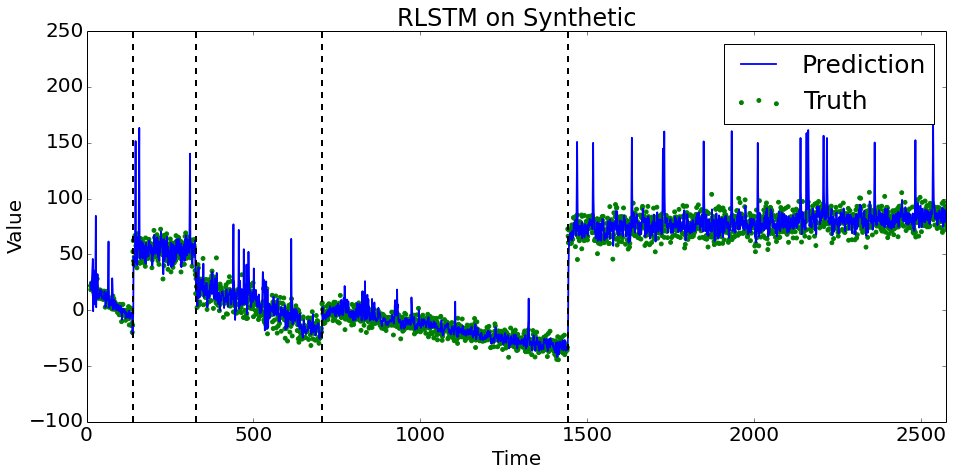

In [19]:
# block7: single run with the best learing rate


dtax, dtay = format_timeseries_rnn( ts_arr[dataset_idx] )

sgd = SGD(lr= 0.004, momentum=0.03, decay=0.0, nesterov=True)
rl_t, rl_tst_x, rl_tst_y, rl_tst_pred_y = rl_train_rnn(dtax, dtay, sgd, loss_func, \
                                                ts_flag_arr[dataset_idx], 0.0001)

tmpmse=test_result_plot(rl_t, rl_tst_x, rl_tst_y, rl_tst_pred_y, "RLSTM" , yrange_arr[dataset_idx], \
                 dataset_names[dataset_idx], True, ts_cpt_arr[dataset_idx], winsize)

nmse_arr[0]=tmpmse

In [65]:
# record all the results
import pickle

pickle.dump(rl_tst_x, open("../res/rl_x"+dataset_names[dataset_idx], "wb") )
pickle.dump(rl_tst_y, open("../res/rl_y"+dataset_names[dataset_idx], "wb") )
pickle.dump(rl_tst_pred_y, open("../res/rl_py"+dataset_names[dataset_idx], "wb") )

print dataset_names[dataset_idx]
print nmse_arr
pickle.dump(nmse_arr, open("../res/nmse_"+dataset_names[dataset_idx], "wb") )


YReal
[10460.585995228032, 16225.462861659691, 660.02181167798733]


In [10]:
#  load the previous results
# for i in range( len(nmse_arr) ):
import pickle
print pickle.load( open("../res/nmse_"+dataset_names[0], "rd") )


[10.891499141447477, 9.7018877014158456, 10.929856088443664]
